In [19]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad
import math
import matplotlib.pyplot as plt

In [15]:
def generate_grid_1d(length, samples=20, initial_coordinate=0.0):
    """Generate an evenly space grid of a given length and a given number of samples."""

    # Generate the grid
    x = torch.linspace(initial_coordinate, initial_coordinate + length, samples, requires_grad=True)

    # Reshape on a column tensor and return
    return x.view(samples, 1)

In [16]:
u_analytic = lambda x: np.sin(2 * np.pi * x / L)

In [17]:
E = 1
A = 1
L = 1
u0 = torch.tensor([0,0])
u0 = u0.to(torch.float32)# Dirichlet boundary conditions for both edges
distLoad = lambda x: 4 * math.pi**2 * torch.sin(2 * math.pi * x / L)

## Main function that does all the heavy-loading:

In [5]:
def PhysicsInformedBarModel(x= generate_grid_1d(1,20,0), x_test =generate_grid_1d(1,100,0) ,E =E,A=A,L=1,u0 = u0,dist_load=distLoad):
    

    class NeuralNetwork(nn.Module):
        def __init__(self):
            super().__init__()
        #self.flatten = nn.Flatten()
            self.stack = nn.Sequential( nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1))

        def forward(self, x):
        #x = self.flatten(x)
            logits = self.stack(x)
            return logits
    model = NeuralNetwork()

    def f(x):
    #g = x.clone().detach().requires_grad_(True)


        u = model.forward(x)
        du = grad(u, x, torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        d2u = E*A*grad(du, x, torch.ones_like(du), create_graph=True)[0]
        return d2u + distLoad(x)
    
    x0 = torch.tensor([0.,1.], requires_grad=True)
    x0 = x0.view(2,1)

    loss_fn = nn.MSELoss()
    def loss_(x,x0):
        u_b = model.forward(x0)
        u_b = torch.squeeze(u_b)
        loss_b = loss_fn(u_b,u0)
        loss_r = loss_fn(f(x), torch.zeros_like(f(x)))
    
        return loss_b + loss_r
    
    

    optimizer = torch.optim.Adam(params=model.parameters())

    epochs = 1000
    a,e,c = [], [] , []
    for epoch in range(epochs):
    
        model.train()
    
    
        optimizer.zero_grad()
        loss = loss_(x,x0)

        r = loss_fn(f(x), torch.zeros_like(f(x)))
        b = loss-r
        loss.backward()
        optimizer.step()
        model.eval()

        a.append(r.detach().numpy())
        e.append(b.detach().numpy())
        c.append(loss.detach().numpy())

        if epoch%50==0:
            print(epoch,"Diff Eq Loss: ", r.detach().numpy(),"||Boundary Loss: ", b.detach().numpy(),"||Total: ", loss.detach().numpy())

    
    return model.forward(x_test), a,e,c

    

In [6]:
x= generate_grid_1d(1,20,0)
x_test =generate_grid_1d(1,100,0)

In [7]:
pinnModel,a,e,c = PhysicsInformedBarModel(x, x_test, E, A, L, u0, dist_load=distLoad) # use the designed custom class from physicsinformed.py file

0 Diff Eq Loss:  739.00195 ||Boundary Loss:  0.004760742 ||Total:  739.0067
50 Diff Eq Loss:  591.91266 ||Boundary Loss:  3.076416 ||Total:  594.9891
100 Diff Eq Loss:  32.700363 ||Boundary Loss:  22.699837 ||Total:  55.4002
150 Diff Eq Loss:  15.706886 ||Boundary Loss:  12.217186 ||Total:  27.924072
200 Diff Eq Loss:  2.0634913 ||Boundary Loss:  6.136643 ||Total:  8.200134
250 Diff Eq Loss:  0.22288 ||Boundary Loss:  3.2056437 ||Total:  3.4285235
300 Diff Eq Loss:  0.0940912 ||Boundary Loss:  1.8122315 ||Total:  1.9063227
350 Diff Eq Loss:  0.07724307 ||Boundary Loss:  1.0582972 ||Total:  1.1355402
400 Diff Eq Loss:  0.04167124 ||Boundary Loss:  0.6094372 ||Total:  0.65110844
450 Diff Eq Loss:  0.021425305 ||Boundary Loss:  0.33352745 ||Total:  0.35495275
500 Diff Eq Loss:  0.010970594 ||Boundary Loss:  0.17352843 ||Total:  0.18449903
550 Diff Eq Loss:  0.0057614837 ||Boundary Loss:  0.08609301 ||Total:  0.09185449
600 Diff Eq Loss:  0.003252312 ||Boundary Loss:  0.040816538 ||Total: 

In [8]:
u_test = pinnModel.detach().numpy()

In [9]:

u_actual = u_analytic(x_test.detach().numpy())
l = np.linspace(0,1,len(u_actual))


Test on the 100 grid points

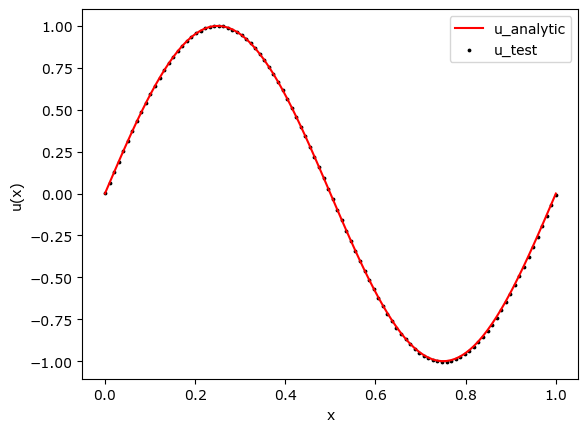

In [18]:
plt.plot(l,u_actual, label= "u_analytic", c = 'r')
#plt.plot(l,u_test, label ="u_test", c = 'black', linestyle='dashdot')
plt.scatter(l,u_test, s = 12, label ="u_test", c = 'black', marker='.')
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()

In [11]:
p = np.arange(1, len(a)+1,1)


In [12]:
a,e,c = np.log(a),np.log(e), np.log(c)

Loss Propagation through the epochs:

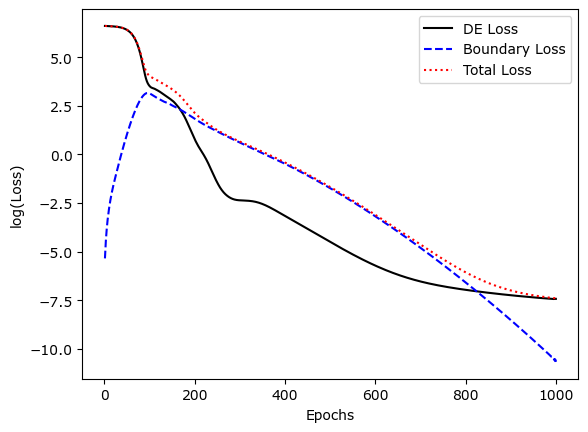

In [13]:
plt.plot(p,a, c='black', label = "DE Loss" )
plt.plot(p,e, c='blue', label="Boundary Loss", linestyle="dashed")
plt.plot(p,c, label = "Total Loss", c='red',linestyle='dotted' )
plt.xlabel("Epochs")
plt.ylabel("log(Loss)")

plt.legend()

Note: I have taken log values of loss(My kernel dies when I use ylabel = log). This is because the loss values are very different in scale. Boundary Loss is in decimals at times hence the wayward curve